# 🤖 | Entrenamiento del modelo

## 📘 | Librerias

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

## 💾 | Cargar los datos

In [2]:
df = pd.read_csv('../data/interim/test.csv')
df.head()

,max_mora,vlr_obligacion,vlr_vencido,saldo_capital,endeudamiento,cant_alter_posibles,cant_gestiones,rpc,promesas_cumplidas,cant_acuerdo,...,canal_actualizacion_PVI,canal_actualizacion_SDI,canal_actualizacion_SIN INFORMACION,canal_actualizacion_SVP,canal_actualizacion_VTC,cli_actualizado_S,cli_actualizado_SIN INFORMACION,ajustes_banco_NO,ajustes_banco_REDIFERIDOS,var_rpta_alt
0,1.724692,-0.347160,-0.089156,0.075375,-0.740556,1.375898,-0.837510,0.267452,-0.321566,-0.53733,...,False,False,False,True,False,False,False,True,False,1
1,-1.012103,-0.017895,0.720256,0.538037,0.254538,-0.938308,-0.996550,0.267452,2.894289,-0.53733,...,False,False,False,True,False,False,False,True,False,1
2,0.169695,-0.464585,0.112622,-0.303575,-0.836656,1.375898,0.991453,0.267452,2.894289,-0.53733,...,False,False,False,True,False,False,False,True,False,1
3,0.667294,2.631318,2.675555,1.424109,1.002099,0.218795,0.832413,-3.738983,4.389577,-0.53733,...,False,False,False,True,False,True,False,True,False,1
4,-0.670004,0.631647,1.379254,0.924983,0.480562,0.218795,-0.280869,0.267452,-0.321566,0.48513,...,False,False,False,True,False,True,False,True,False,0


## ✂️ | Separar a X y Y

Se separa la variable objetivo de las variables posiblemente predictoras porque es necesario identificar claramente qué variable se desea predecir (en este caso, `var_rpta_alt`) y cuáles serán las características utilizadas para entrenar el modelo. Esto permite construir un modelo supervisado, donde las variables predictoras (`X`) se utilizan para aprender patrones que expliquen o predigan la variable objetivo (`y`). Además, esta separación facilita la preparación de los datos, como la selección de características, la normalización y la división en conjuntos de entrenamiento y prueba.

In [3]:
target = 'var_rpta_alt'
X = df.drop(columns=[target])
y = df[target]
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (568251, 151)
y shape: (568251,)


## 🫵🏻 | Selección de variables 

Se deben seleccionar las variables más importantes para la predicción del modelo a través de `SelectKBest`, ya que este método permite identificar las características que tienen mayor relevancia en relación con la variable objetivo. Esto se logra evaluando cada variable de forma individual mediante una métrica estadística específica, como la información mutua (`mutual_info_classif`), que mide la dependencia entre las variables predictoras y la variable objetivo. Al seleccionar únicamente las variables más significativas, se mejora la eficiencia del modelo, se reduce el riesgo de sobreajuste y se facilita la interpretación de los resultados.

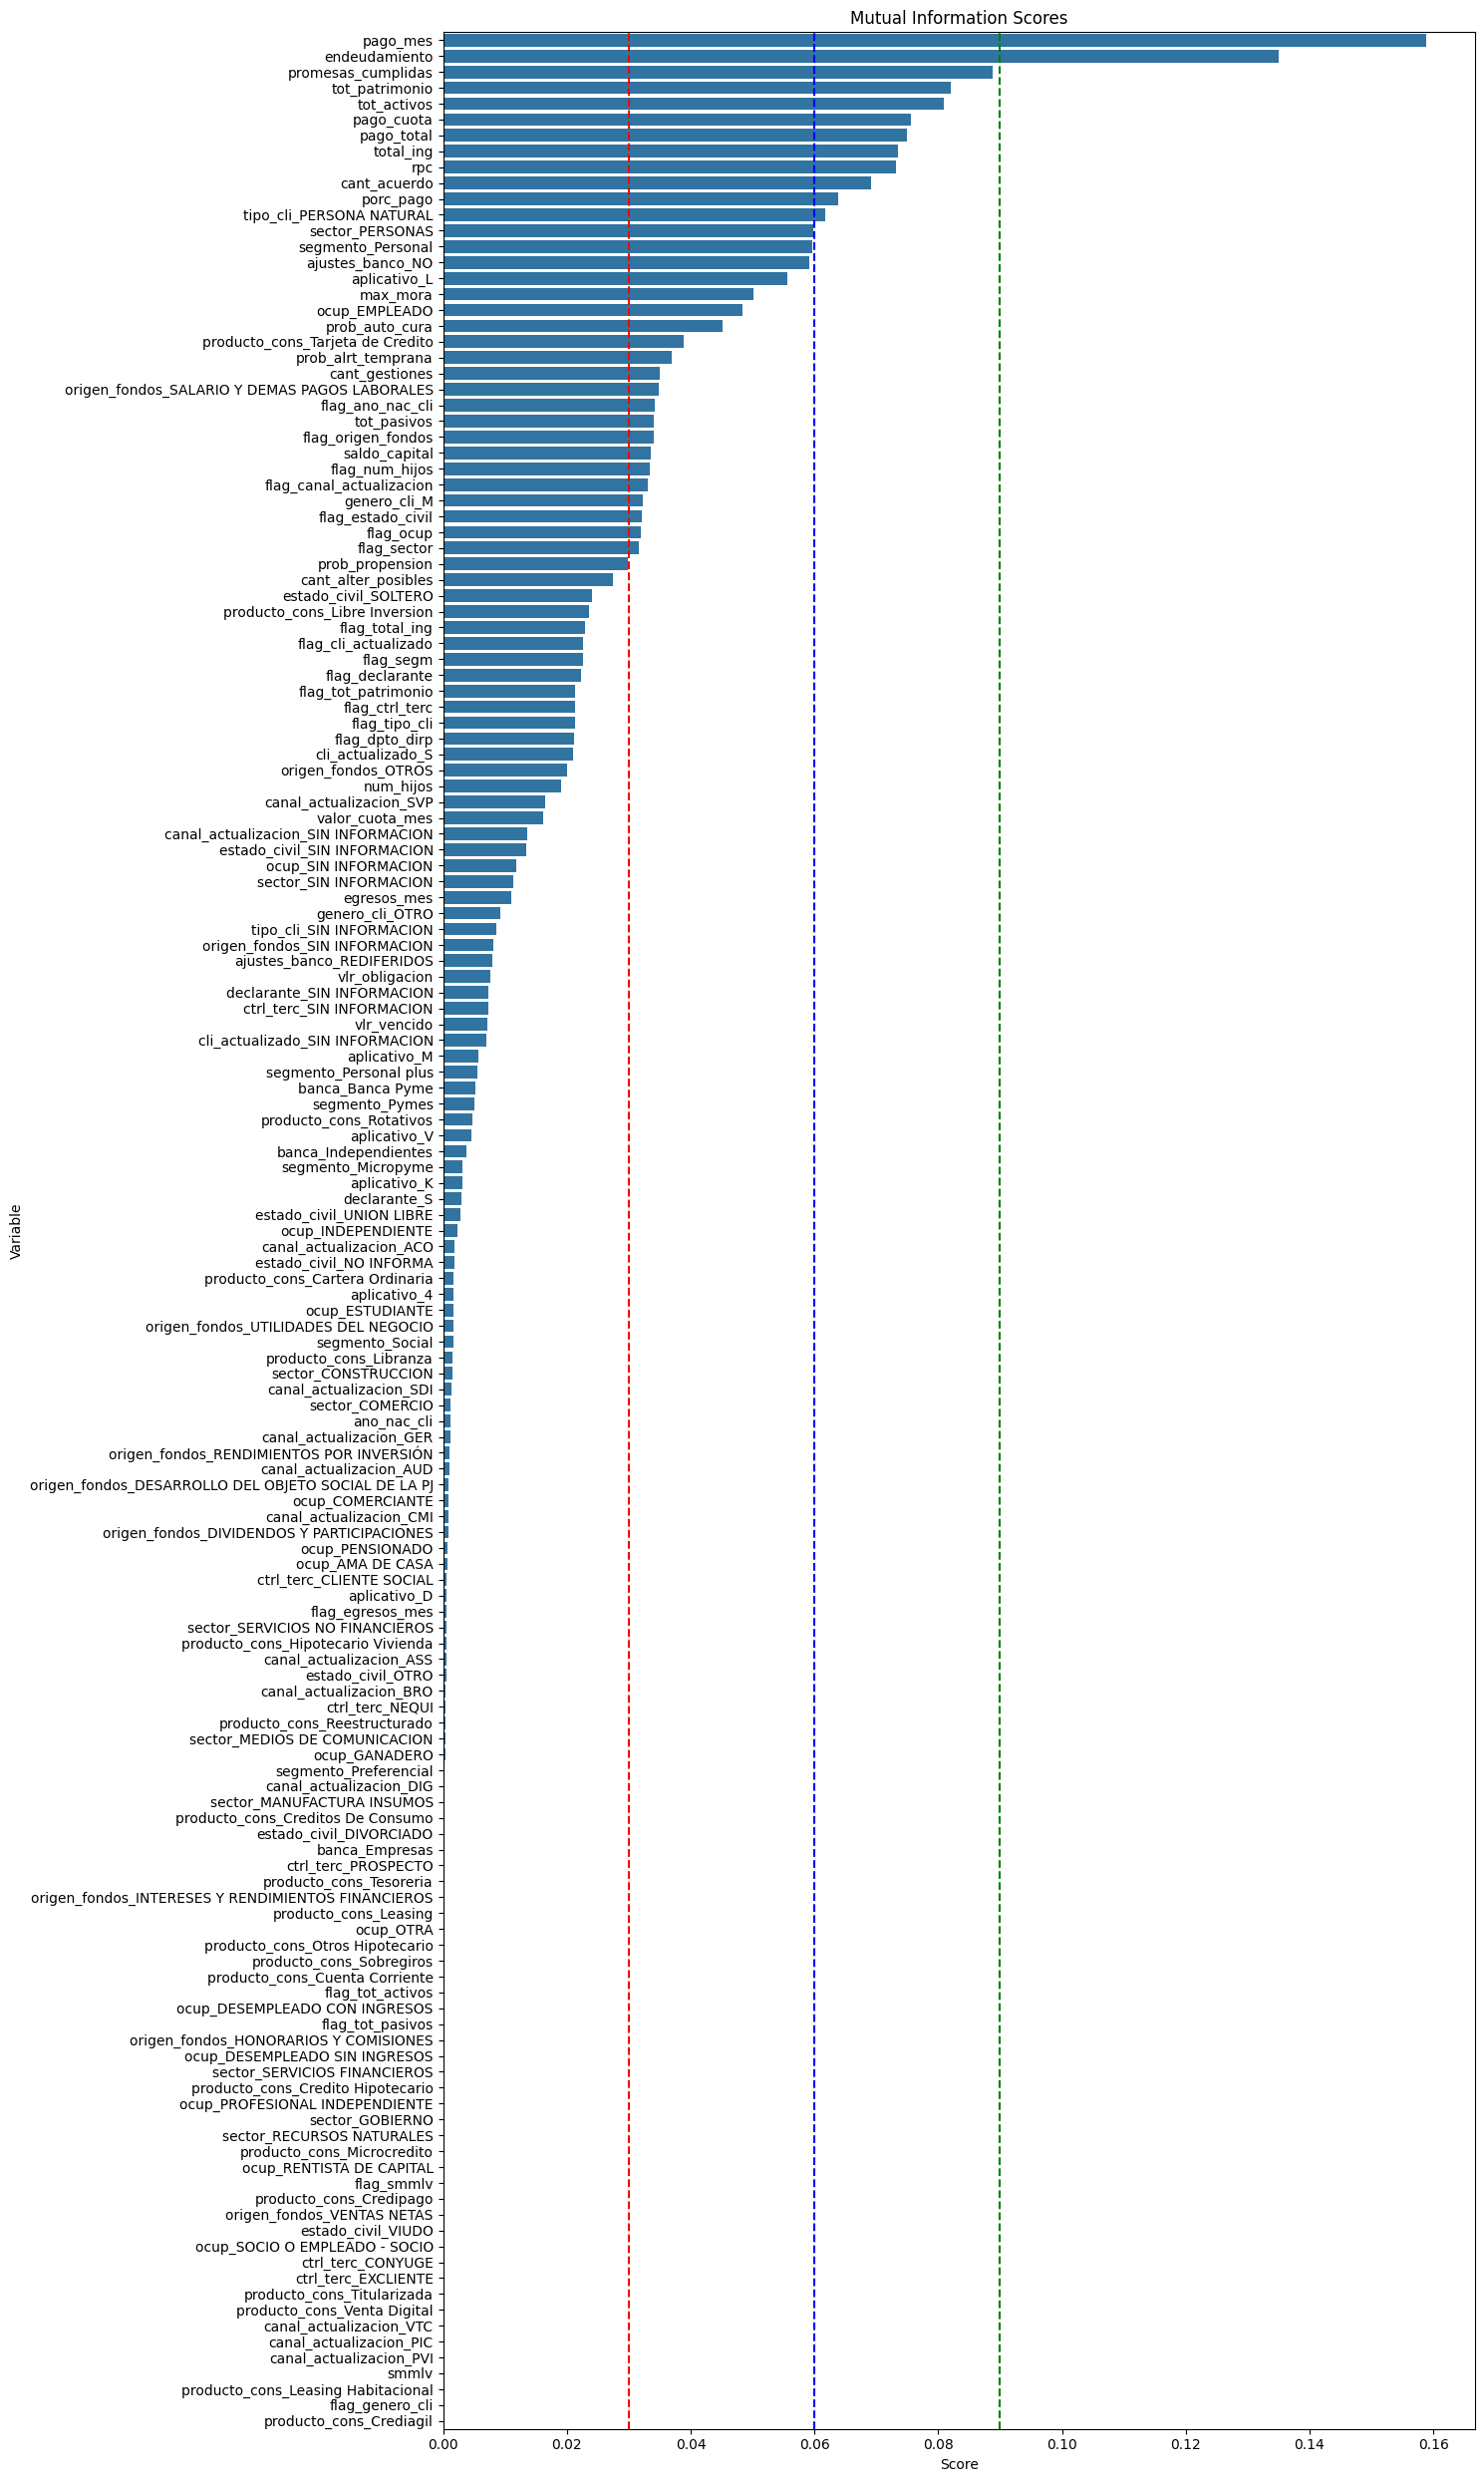

,Variable,Score
0,pago_mes,0.158794
1,endeudamiento,0.135074
2,promesas_cumplidas,0.088804
3,tot_patrimonio,0.082027
4,tot_activos,0.080891
5,pago_cuota,0.075548
6,pago_total,0.075005
7,total_ing,0.073426
8,rpc,0.073176
9,cant_acuerdo,0.069101


In [4]:
# Calcular los scores
selector = SelectKBest(score_func=mutual_info_classif, k='all')
selector.fit(X, y)

# Mostrar los scores en un DataFrame
scores = pd.DataFrame({
    'Variable': X.columns,
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False)

scores.sort_values(by='Score', ascending=False, inplace=True)
scores.reset_index(drop=True, inplace=True)

plt.figure(figsize=(15, 25))
sns.barplot(x='Score', y='Variable', data=scores)
plt.title('Mutual Information Scores')
plt.xlabel('Score')
plt.ylabel('Variable')
plt.axvline(x=0.03, color='red', linestyle='--')
plt.axvline(x=0.06, color='blue', linestyle='--')
plt.axvline(x=0.09, color='green', linestyle='--')
plt.tight_layout()
plt.show()

selected_cols = [
    'max_mora', 
    'endeudamiento', 
    'rpc', 
    'promesas_cumplidas', 
    'cant_acuerdo', 
    'pago_cuota', 
    'pago_mes', 
    'total_ing', 
    'tot_activos', 
    'tot_patrimonio', 
    'pago_total', 
    'porc_pago', 
    'prob_auto_cura', 
    'segmento_Personal', 
    'producto_cons_Tarjeta de Credito', 
    'aplicativo_L', 
    'tipo_cli_PERSONA NATURAL', 
    'ocup_EMPLEADO', 
    'sector_PERSONAS', 
    'ajustes_banco_NO'
    ]
cols_scores = scores[scores['Variable'].isin(selected_cols)].reset_index(drop=True)
cols_scores

De las 20 variables sugeridas por `SelectKBest`, se decide seleccionar las 9 variables con mejor puntuación, ya que un modelo con demasiadas variables puede ser difícil de interpretar y computacionalmente más costoso. Es importante destacar que esta selección debe realizarse en colaboración con expertos del negocio, quienes pueden aportar un conocimiento profundo sobre el contexto y la relevancia de cada variable. Este enfoque no solo mejora la interpretabilidad del modelo, sino que también asegura que las variables elegidas tengan un impacto significativo y estén alineadas con los objetivos del análisis.

In [5]:
X_selected = [
    'pago_mes',
    'endeudamiento',
    'promesas_cumplidas',
    'tot_patrimonio',
    'tot_activos',
    'pago_cuota',
    'total_ing',
    'pago_total',
    'rpc'
]

## ➗ | División train y test

Se deben divir los datos entre train y test, esto permite evaluar el rendimiento del modelo de manera objetiva. Al separar los datos en un conjunto de entrenamiento (`train`) y un conjunto de prueba (`test`), el modelo se entrena únicamente con los datos de entrenamiento y se evalúa con datos no vistos previamente (los datos de prueba). Esto ayuda a medir la capacidad del modelo para generalizar a nuevos datos, evitando problemas como el sobreajuste y asegurando que el modelo sea útil en escenarios del mundo real.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_selected = X_train[X_selected]
X_test_selected = X_test[X_selected]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (397775, 151)
X_test shape: (170476, 151)
y_train shape: (397775,)
y_test shape: (170476,)


## 🪖 | Entrenamiento de los modelos base

Se entrenan tres modelos de clasificación con el objetivo de determinar cuál obtiene el mejor F1-Score. Los modelos utilizados son: **Logistic Regression**, **Random Forest** y **XGBoost**. Cada modelo se entrena utilizando los datos de entrenamiento previamente seleccionados y se evalúa su desempeño en el conjunto de prueba. El F1-Score se utiliza como métrica principal debido a su capacidad para balancear precisión y recall, lo que resulta especialmente útil en problemas con clases desbalanceadas.

In [7]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

f1_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores[name] = f1
    print(f"{name} - F1 Score: {f1:.4f}")

Logistic Regression - F1 Score: 0.7647
Random Forest - F1 Score: 0.8445
XGBoost - F1 Score: 0.8422


## 🔀 | Validación cruzada

La validación cruzada es una técnica utilizada para evaluar el rendimiento de un modelo de aprendizaje supervisado. Consiste en dividir el conjunto de datos en múltiples subconjuntos o "folds", donde en cada iteración se utiliza uno de estos subconjuntos como conjunto de prueba y el resto como conjunto de entrenamiento. Este proceso se repite varias veces, asegurando que cada subconjunto sea utilizado como conjunto de prueba al menos una vez.

In [8]:
X_selected = X[X_selected]

for name, model in models.items():
    scores = cross_val_score(model, X_selected, y, cv=5, scoring='f1')
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

Logistic Regression: 0.7145 ± 0.0145
Random Forest: 0.6987 ± 0.0097
XGBoost: 0.7143 ± 0.0143


## 🎖️ | Modelo elegido

Se elige el modelo de **Logistic Regression** porque, a pesar de ser un modelo simple, obtuvo un **F1-Score promedio de 0.7145 ± 0.0145** en la validación cruzada, lo cual es competitivo en comparación con otros modelos más complejos. Este modelo tiene varias ventajas:

1. **Interpretabilidad**: Logistic Regression es fácil de interpretar, ya que permite entender cómo cada variable afecta la probabilidad de la clase objetivo. Esto es especialmente útil para comunicar resultados a equipos no técnicos.

2. **Eficiencia computacional**: Es menos costoso en términos de tiempo y recursos computacionales, lo que lo hace ideal para escenarios donde se requiere rapidez en el entrenamiento y predicción.

3. **Generalización**: Al ser un modelo menos complejo, tiene menor riesgo de sobreajuste, lo que asegura un buen desempeño en datos no vistos.

4. **Simplicidad**: La simplicidad del modelo facilita su implementación y mantenimiento en producción, especialmente en sistemas donde la robustez y la facilidad de actualización son importantes.

Aunque otros modelos como **Random Forest** y **XGBoost** obtuvieron métricas ligeramente superiores, la elección de Logistic Regression se basa en un balance entre rendimiento, interpretabilidad y simplicidad, lo que lo convierte en una opción adecuada para este caso de uso.

In [9]:
X_model = X_train_selected
y_model = y_train

final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_model, y_model)

# f1-score
y_pred = final_model.predict(X_test_selected)
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7145


## 📈 | Metricas del modelo

Las métricas son fundamentales para evaluar el desempeño de un modelo de clasificación, ya que permiten medir su capacidad para realizar predicciones correctas y su comportamiento en diferentes aspectos. Las métricas empleadas en este análisis son:

1. **Accuracy**: Proporción de predicciones correctas sobre el total de predicciones realizadas.
2. **Precision**: Proporción de verdaderos positivos sobre el total de predicciones positivas realizadas por el modelo.
3. **Recall**: Proporción de verdaderos positivos sobre el total de casos positivos reales.
4. **F1-Score**: Media armónica entre precisión y recall, útil en casos de clases desbalanceadas.
5. **ROC AUC Score**: Área bajo la curva ROC, que mide la capacidad del modelo para distinguir entre clases.
6. **Reporte de Clasificación**: Resumen detallado de precisión, recall y F1-Score para cada clase.
7. **Matriz de Confusión**: Tabla que muestra los verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.

In [ ]:
y_pred = final_model.predict(X_test_selected)
y_prob = final_model.predict_proba(X_test_selected)[:, 1]

print("===== Métricas del Modelo =====")
print(f"Accuracy     : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision    : {precision_score(y_test, y_pred):.4f}")
print(f"Recall       : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score     : {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

print("\n===== Reporte de Clasificación =====")
print(classification_report(y_test, y_pred))

print("===== Matriz de Confusión =====")
print(confusion_matrix(y_test, y_pred))

===== Métricas del Modelo =====
Accuracy     : 0.7793
Precision    : 0.9423
Recall       : 0.5754
F1 Score     : 0.7145
ROC AUC Score: 0.8147

===== Reporte de Clasificación =====
              precision    recall  f1-score   support

           0       0.71      0.97      0.82     88663
           1       0.94      0.58      0.71     81813

    accuracy                           0.78    170476
   macro avg       0.83      0.77      0.77    170476
weighted avg       0.82      0.78      0.77    170476

===== Matriz de Confusión =====
[[85779  2884]
 [34736 47077]]


### Interpretación de los resultados:

1. **Accuracy (77.93%)**: El modelo tiene un desempeño general aceptable, logrando predecir correctamente el 77.93% de los casos. Sin embargo, esta métrica puede ser engañosa en problemas con clases desbalanceadas.

2. **Precision (94.23%)**: El modelo es muy preciso al identificar la clase positiva (1), lo que significa que la mayoría de las predicciones positivas realizadas son correctas. Esto es importante en escenarios donde los falsos positivos tienen un alto costo.

3. **Recall (57.54%)**: El modelo tiene dificultades para identificar todos los casos positivos reales, ya que solo detecta el 57.54% de ellos. Esto puede ser problemático en aplicaciones donde es crucial minimizar los falsos negativos.

4. **F1-Score (71.45%)**: Este valor refleja un balance entre precisión y recall. Aunque la precisión es alta, el bajo recall afecta el F1-Score, indicando que el modelo podría mejorar en la detección de casos positivos.

5. **ROC AUC Score (81.47%)**: El modelo tiene una buena capacidad para distinguir entre clases, con un área bajo la curva ROC de 81.47%. Esto sugiere que el modelo es efectivo en términos de discriminación.

6. **Reporte de Clasificación**:
   - Para la clase 0 (negativa), el modelo tiene un buen desempeño con un F1-Score de 82%.
   - Para la clase 1 (positiva), el F1-Score es de 71%, lo que indica que el modelo tiene más dificultades para predecir esta clase.

7. **Matriz de Confusión**:
   - Verdaderos positivos (TP): 47,077 casos de la clase 1 fueron correctamente identificados.
   - Verdaderos negativos (TN): 85,779 casos de la clase 0 fueron correctamente identificados.
   - Falsos positivos (FP): 2,884 casos de la clase 0 fueron incorrectamente clasificados como 1.
   - Falsos negativos (FN): 34,736 casos de la clase 1 fueron incorrectamente clasificados como 0.

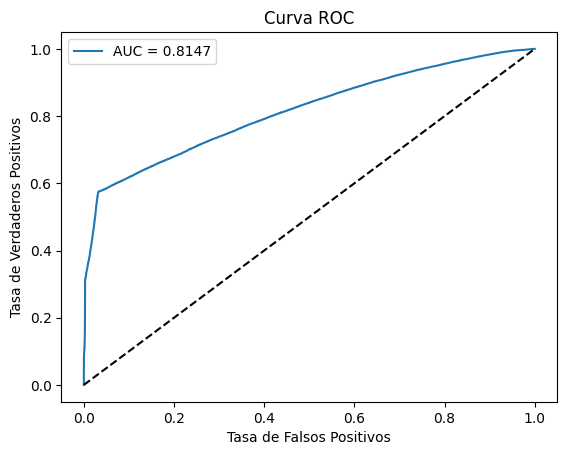

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend()
plt.show()

El modelo tiene un buen desempeño general, especialmente en términos de precisión y capacidad de discriminación (ROC AUC). Sin embargo, el bajo recall para la clase positiva indica que el modelo no está capturando todos los casos positivos, lo que podría ser un área de mejora dependiendo del caso de uso. Si el objetivo es minimizar los falsos negativos, se podrían ajustar los umbrales de decisión o explorar técnicas adicionales como el balanceo de clases o la optimización de hiperparámetros.

In [21]:
pred_df = pd.DataFrame({
    "real": y_test,
    "predicho": y_pred,
    "probabilidad": y_prob
})

print("✅ Casos con alta probabilidad de aceptar (modelo muy confiado):")
print(pred_df.sort_values("probabilidad", ascending=False).head(10))

print("❌ Casos con baja probabilidad (modelo dudoso o que falló):")
print(pred_df.sort_values("probabilidad").head(10))


✅ Casos con alta probabilidad de aceptar (modelo muy confiado):
        real  predicho  probabilidad
298131     1         1           1.0
390710     1         1           1.0
252776     1         1           1.0
430710     1         1           1.0
188346     1         1           1.0
35253      1         1           1.0
299768     1         1           1.0
350480     1         1           1.0
310190     1         1           1.0
120859     1         1           1.0
❌ Casos con baja probabilidad (modelo dudoso o que falló):
        real  predicho  probabilidad
297653     0         0      0.019243
289995     0         0      0.022290
292005     0         0      0.022451
302448     0         0      0.022547
292553     0         0      0.022693
290724     0         0      0.024963
293295     0         0      0.026639
292163     0         0      0.026767
290430     0         0      0.026945
290823     0         0      0.027075


El análisis de decil es una técnica utilizada para dividir un conjunto de datos en 10 grupos (deciles) de igual tamaño, ordenados según una métrica específica, en este caso, la probabilidad de aceptación predicha por el modelo. Este análisis permite evaluar cómo se comporta la tasa real de aceptación en cada decil, proporcionando información sobre la capacidad del modelo para discriminar entre casos positivos y negativos.

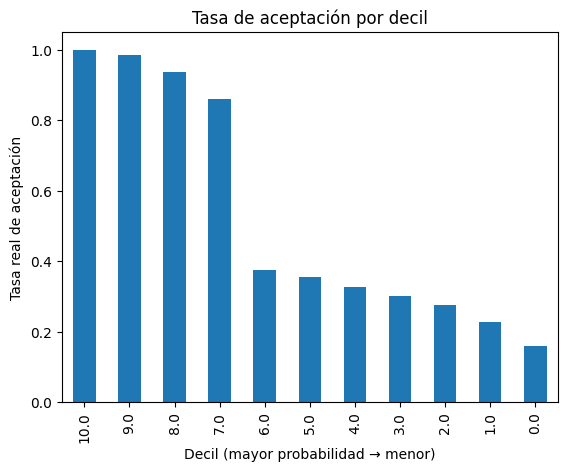

In [22]:
pred_df['decil'] = pred_df['probabilidad'].rank(method='first', pct=True) * 10 // 1

decil_analysis = pred_df.groupby('decil')['real'].mean().sort_index(ascending=False)
decil_analysis.plot(kind='bar')
plt.title("Tasa de aceptación por decil")
plt.xlabel("Decil (mayor probabilidad → menor)")
plt.ylabel("Tasa real de aceptación")
plt.show()


### Interpretación de los resultados:
1. **Deciles superiores (10.0 a 7.0)**: 
    - Los deciles superiores tienen tasas de aceptación muy altas, con el decil 10 alcanzando el 100% y el decil 9 el 98.62%. Esto indica que el modelo es muy confiable al clasificar los casos con mayor probabilidad de aceptación.
    - Estos deciles representan los casos en los que el modelo tiene mayor confianza y predice correctamente la mayoría de los casos positivos.

2. **Deciles intermedios (6.0 a 4.0)**:
    - En estos deciles, la tasa de aceptación disminuye significativamente, con valores entre el 37.36% y el 32.69%. Esto sugiere que el modelo comienza a tener más dificultades para discriminar entre casos positivos y negativos en esta región.

3. **Deciles inferiores (3.0 a 0.0)**:
    - Los deciles inferiores tienen tasas de aceptación mucho más bajas, con el decil 0 alcanzando solo el 15.80%. Esto indica que el modelo identifica correctamente la mayoría de los casos negativos en esta región, pero también puede estar perdiendo algunos casos positivos.

El análisis de decil muestra que el modelo tiene un buen desempeño en los deciles superiores, donde concentra la mayoría de los casos positivos. Sin embargo, en los deciles intermedios e inferiores, la capacidad del modelo para discriminar entre clases disminuye. Esto puede ser útil para priorizar acciones en los casos con mayor probabilidad de aceptación (deciles superiores) y para identificar áreas de mejora en la clasificación de los casos menos seguros (deciles intermedios e inferiores).

## 🛫 | Exportar modelo y las columnas elegidas

In [24]:
with open("../models/modelo_logistic_regression.pkl", "wb") as f:
    model = final_model
    pickle.dump(model, f)


with open("../models/columnas_modelo_lr.pkl", "wb") as f:
    pickle.dump(X_model.columns.tolist(), f)